In [ ]:

# === 1. Import libraries and setup ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import zipfile
import random
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# Setup device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    # Clean cache GPU
    torch.cuda.empty_cache()

Using device: cuda
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
# load dataset
IMG_DIR_PART1 = 'HAM10000_images_part_1'
IMG_DIR_PART2 = 'HAM10000_images_part_2'
CONSOLIDATED_IMG_DIR = 'HAM10000_images'
df = pd.read_csv('HAM10000_metadata')
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


In [ ]:
CONSOLIDATED_IMG_DIR = 'HAM10000_images'
if not os.path.exists(CONSOLIDATED_IMG_DIR):
    os.makedirs(CONSOLIDATED_IMG_DIR)
    for img_dir in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
        for img_file in os.listdir(img_dir):
            shutil.copy(os.path.join(img_dir, img_file), CONSOLIDATED_IMG_DIR)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(CONSOLIDATED_IMG_DIR, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)]
print("Filtered DataFrame shape:", df.shape)

In [ ]:
# Map short class names to full names
class_name_mapping = {
    'nv': 'Melanocytic_nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign_keratosislike_lesions',
    'bcc': 'Basal_cell_carcinoma',
    'akiec': 'Actinic_keratoses',
    'vasc': 'Vascular_lesions',
    'df': 'Dermatofibroma'
}
df['dx_full'] = df['dx'].map(class_name_mapping)


Class distribution BEFORE filtering:
dx_full
Melanocytic_nevi                6705
Melanoma                        1113
Benign_keratosislike_lesions    1099
Basal_cell_carcinoma             514
Actinic_keratoses                327
Vascular_lesions                 142
Dermatofibroma                   115
Name: count, dtype: int64

Filtering classes with less than 500 samples...
Classes to keep: ['Melanocytic_nevi', 'Melanoma', 'Benign_keratosislike_lesions', 'Basal_cell_carcinoma']

Class distribution AFTER filtering:
dx_full
Melanocytic_nevi                6705
Melanoma                        1113
Benign_keratosislike_lesions    1099
Basal_cell_carcinoma             514
Name: count, dtype: int64

Filtered DataFrame shape: (9431, 10)
Number of classes to train on: 4


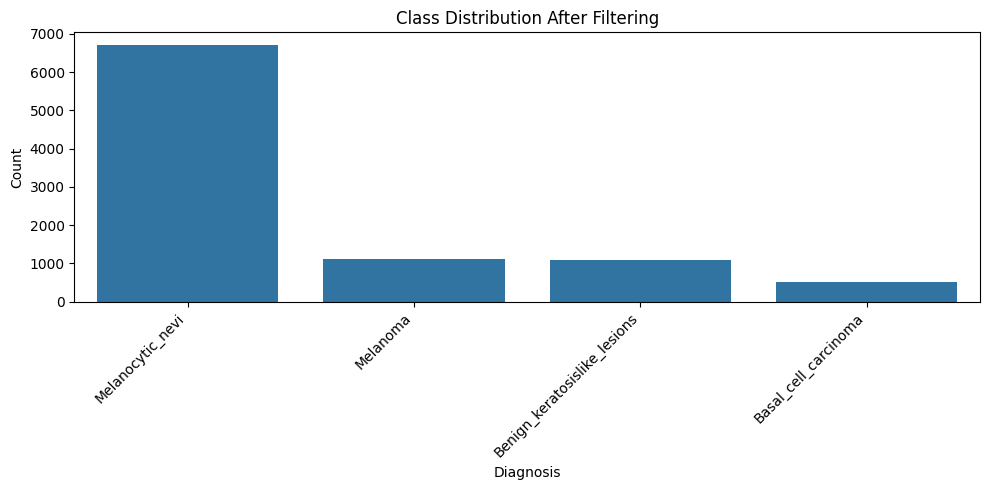

In [ ]:
print("\nClass distribution BEFORE filtering:")
print(df['dx_full'].value_counts())

min_samples = 500
# 1. samples in each class
class_counts = df['dx_full'].value_counts()

# 2. cut classes with less than min_samples
classes_to_keep = class_counts[class_counts >= min_samples].index.tolist()
print(f"Classes to keep: {classes_to_keep}")

# 3. filter DataFrame
df_filtered = df[df['dx_full'].isin(classes_to_keep)].copy()

print("\nClass distribution AFTER filtering:")
final_class_counts = df_filtered['dx_full'].value_counts()
print(final_class_counts)
print("\nFiltered DataFrame shape:", df_filtered.shape)

num_classes = len(final_class_counts) # number of classes after filtering
print(f"Number of classes to train on: {num_classes}")
if num_classes == 0: raise ValueError("No classes left after filtering!")

# visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df_filtered, x='dx_full', order=df_filtered['dx_full'].value_counts().index)
plt.title('Class Distribution After Filtering')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Encode labels
le = LabelEncoder()
# Add 'label' to df_filtered
df_filtered['label'] = le.fit_transform(df_filtered['dx'])
# save classes
class_names = le.classes_
print("\nEncoded labels for filtered data using column 'dx'. Classes:", class_names)

if 'class_name_mapping' not in locals():
     # doublecheck
     class_name_mapping = {
         'nv': 'Melanocytic_nevi', 'mel': 'Melanoma', 'bkl': 'Benign_keratosislike_lesions',
         'bcc': 'Basal_cell_carcinoma', 'akiec': 'Actinic_keratoses',
         'vasc': 'Vascular_lesions', 'df': 'Dermatofibroma'
     }
# dictionary class index -> full name
idx_to_fullname_map = {idx: class_name_mapping.get(cls_short, cls_short) # use get for safety
                       for idx, cls_short in enumerate(class_names)}
# list of full names in correct order for sklearn
report_target_names = [idx_to_fullname_map[i] for i in range(num_classes)]
print("\nEncoded labels. Index to full name mapping for reports:", idx_to_fullname_map)
print("Target names for classification report:", report_target_names)

# Split the dataset
train_df, temp_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['label'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)
print(f"\nFinal split sizes: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")


Encoded labels for filtered data using column 'dx'. Classes: ['bcc' 'bkl' 'mel' 'nv']

Encoded labels. Index to full name mapping for reports: {0: 'Basal_cell_carcinoma', 1: 'Benign_keratosislike_lesions', 2: 'Melanoma', 3: 'Melanocytic_nevi'}
Target names for classification report: ['Basal_cell_carcinoma', 'Benign_keratosislike_lesions', 'Melanoma', 'Melanocytic_nevi']

Final split sizes: Train=7544, Validation=943, Test=944


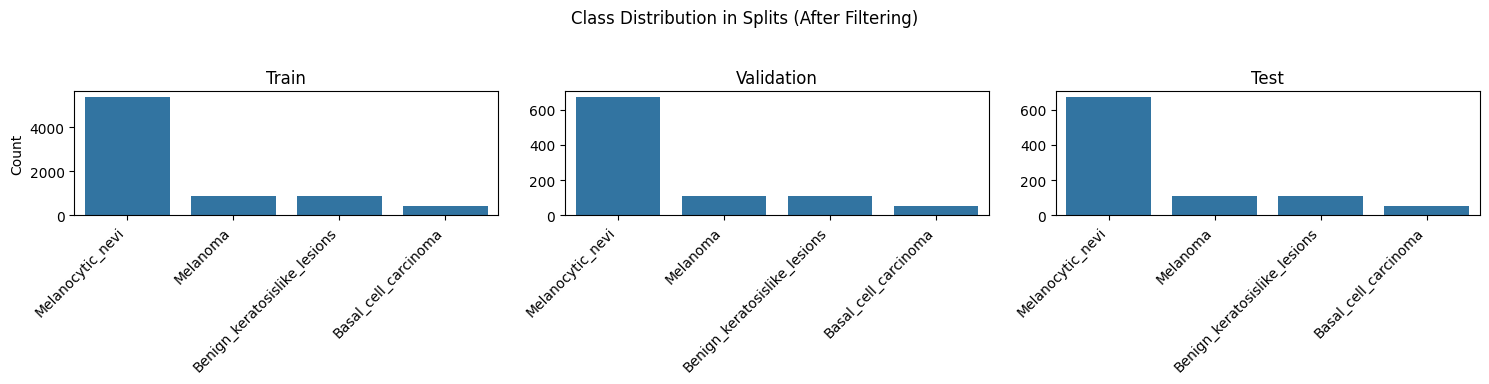

In [ ]:
# visualization
plt.figure(figsize=(15, 4))
order_for_plots = df_filtered['dx_full'].value_counts().index
for i, subset in enumerate([train_df, val_df, test_df]):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=subset['dx_full'], order=order_for_plots)
    plt.title(['Train', 'Validation', 'Test'][i])
    plt.xlabel(None)
    plt.ylabel('Count' if i == 0 else None)
    plt.xticks(rotation=45, ha='right')
plt.suptitle("Class Distribution in Splits (After Filtering)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Displaying random samples from the filtered dataset:


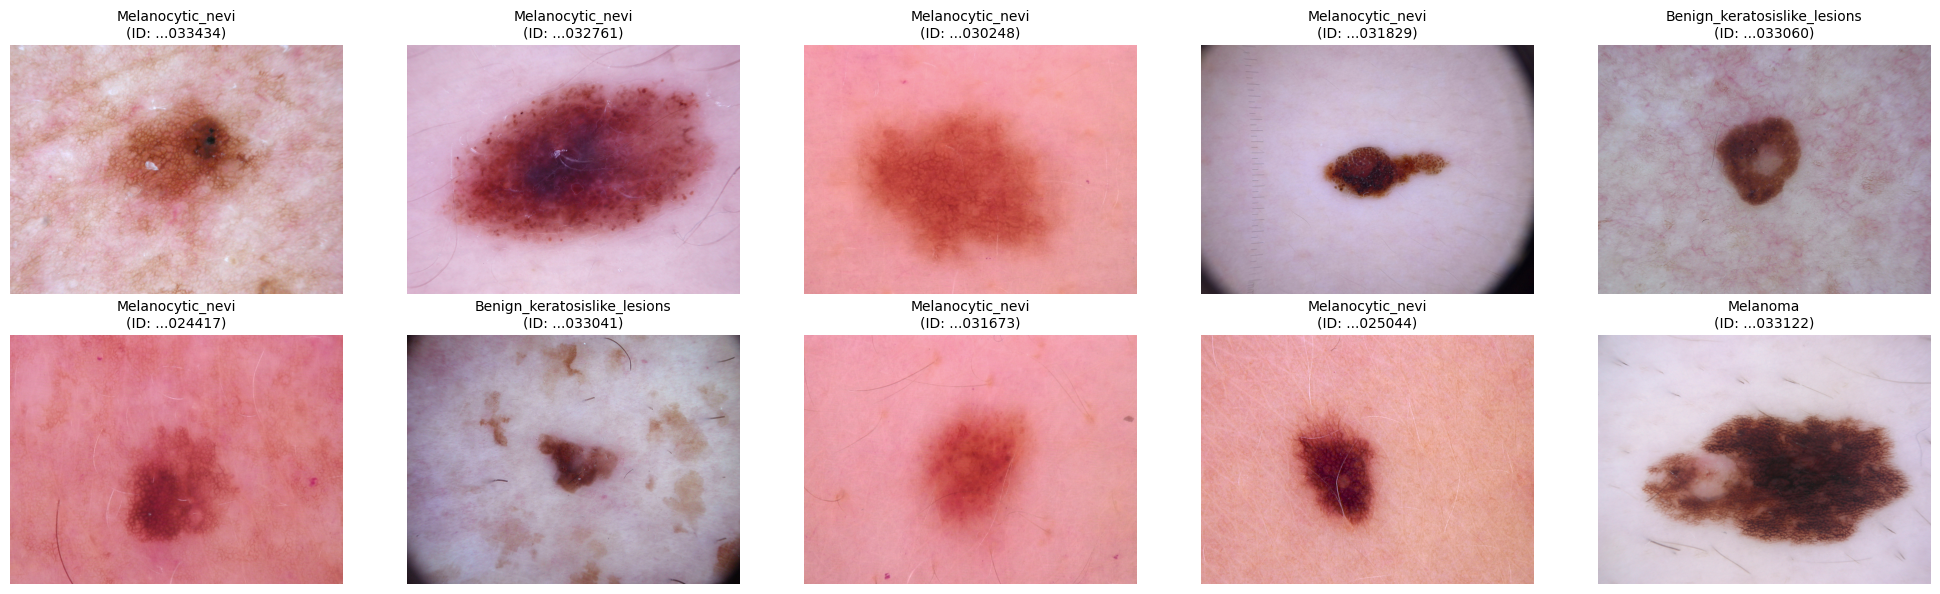

In [ ]:
# show random samples
print("\nDisplaying random samples from the filtered dataset:")
num_samples_to_show = min(10, len(df_filtered))
if num_samples_to_show > 0:
    sample_df = df_filtered.sample(num_samples_to_show, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(20, 6) if num_samples_to_show > 5 else (num_samples_to_show * 4, 4))
    rows = (num_samples_to_show + 4) // 5
    for i, row in sample_df.iterrows():
        img_path = row['image_path']
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read sample image {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(rows, 5, i + 1)
            plt.imshow(img)
            plt.title(f"{row['dx_full']}\n(ID: ...{row['image_id'][-6:]})", fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")

    plt.tight_layout()
    plt.show()
else:
    print("Not enough samples in the filtered dataset to display.")

In [ ]:
# === 3. Dataset, Augmentations, DataLoader ===
IMG_SIZE = 224
BATCH_SIZE = 16 # Начни с 16, подбирай под RTX 4060 (8GB)
print(f"Using Batch Size: {BATCH_SIZE}")

NUM_WORKERS = 0 if os.name == 'nt' else min(os.cpu_count() // 2, 4)
print(f"Using DataLoader Workers: {NUM_WORKERS}")

# ---  Albumentations ---
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.RandomRotate90(p=0.5), A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.7, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()
])

# --- Custom PyTorch Dataset ---
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self.file_paths = self.df['image_path'].values
        self.labels = self.df['label'].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = None
        try:
            # load in RGB
            image_bgr = cv2.imread(img_path)
            if image_bgr is None:
                print(f"W: Img None {img_path}. Fallback.")
                fallback_idx=(idx-1)%len(self) if len(self)>0 else 0
                if idx == fallback_idx:
                    print(f"E: Cannot fallback for idx {idx}. Return None.")
                    return None,None
                else:
                    return self.__getitem__(fallback_idx)
            image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        except Exception as e:
             print(f"E: Load/Cvt {img_path}: {e}. Fallback.")
             fallback_idx=(idx-1)%len(self) if len(self)>0 else 0
             if idx == fallback_idx:
                 print(f"E: Cannot fallback for idx {idx} during exception. Return None.")
                 return None, None
             else:
                 return self.__getitem__(fallback_idx)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            try:
                image = self.transform(image=image)['image']
            except Exception as e:
                 print(f"E: transform {img_path}: {e}. Basic.")
                 transform_fallback = A.Compose([A.Resize(IMG_SIZE,IMG_SIZE), A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), ToTensorV2()])
                 try:
                     image = transform_fallback(image=image)['image']
                 except Exception as fe:
                     print(f"E: fallback transform {img_path}: {fe}. Return None.")
                     return None, None
        return image, label

# --- Helping function for DataLoader (ignores None) ---
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    if not batch:
        return None, None
    try:
        # standerd collate for batch of rest elements
        return torch.utils.data.dataloader.default_collate(batch)
    except Exception as e:
        print(f"E: Error in default_collate: {e}")
        return None, None

# --- Create instants Dataset ---
try:
    train_dataset = SkinDataset(train_df, transform=train_transform)
    val_dataset = SkinDataset(val_df, transform=val_test_transform)
    test_dataset = SkinDataset(test_df, transform=val_test_transform)
    print("Dataset instances created successfully.")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
except NameError as e:
     print(f"Error creating Datasets: {e}")
     print("Make sure train_df, val_df, and test_df were defined correctly in the previous steps.")
     raise

# --- Create DataLoaders with collate_fn ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', drop_last=True, collate_fn=collate_fn_skip_none)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', collate_fn=collate_fn_skip_none)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=device.type=='cuda', collate_fn=collate_fn_skip_none)
print("DataLoaders created.")

# --- Check one batch ---
try:
    batch_data = next(iter(train_loader))
    if batch_data is not None and batch_data[0] is not None:
        images, labels = batch_data
        print(f"Sample batch retrieved: Images shape={images.shape}, Labels shape={labels.shape}")
    elif batch_data is None or (isinstance(batch_data, tuple) and batch_data[0] is None):
         print("Retrieved an empty batch (possibly due to loading errors in the first batch).")
    else:
         print(f"Retrieved batch data in unexpected format: {type(batch_data)}")
except StopIteration:
     print("Error: DataLoader is empty. Check dataset creation and filtering.")
except Exception as e:
    print(f"Error checking DataLoader: {e}. Consider setting NUM_WORKERS=0.")

# --- clean RAM from useless DataFrames ---
try:
    del train_df, val_df, test_df, temp_df, df_filtered, df, class_counts, final_class_counts
    gc.collect()
    print("DataFrames deleted.")
except NameError:
    print("Some DataFrames may have already been deleted or were not defined.")

Using Batch Size: 16
Using DataLoader Workers: 0

Creating Dataset instances...
Dataset instances created successfully.
Train dataset size: 7544
Validation dataset size: 943
Test dataset size: 944

Creating DataLoaders...
DataLoaders created.

Checking DataLoader integrity...
Sample batch retrieved: Images shape=torch.Size([16, 3, 224, 224]), Labels shape=torch.Size([16])

Deleting unused DataFrames...


Exception ignored in: <function tqdm.__del__ at 0x000001FFE4D4D3F0>
Traceback (most recent call last):
  File "C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\maria\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


DataFrames deleted.


In [ ]:
# === 4. Define Model ===
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters(): param.requires_grad = False
num_ftrs = model.classifier[1].in_features
if 'num_classes' not in locals() or num_classes <= 0:
     raise ValueError("Number of classes not determined correctly in data preparation.")
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
print(f"Replaced classifier layer for {num_classes} classes.")
model = model.to(device)


Loading pre-trained EfficientNet-B0 model...
Freezing base model parameters...
Replaced classifier layer for 4 classes.


In [ ]:
# === 6. Loss, Optimizer, Scheduler, Class Weights ===
try:
    if 'train_dataset' not in locals():
         raise NameError("train_dataset is not defined. Cannot calculate class weights.")
    y_train_encoded = train_dataset.labels
    if len(np.unique(y_train_encoded)) != num_classes:
         print(f"Warning: Number of unique labels in train_dataset ({len(np.unique(y_train_encoded))}) doesn't match num_classes ({num_classes}). Check data.")
    # calculate weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print("Calculated Class Weights:", class_weights_tensor)
    # use weighted loss
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print("Loss function: Weighted CrossEntropyLoss")
except NameError as e:
    print(f"Error calculating class weights (NameError): {e}. Using unweighted CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()
    print("Loss function: Unweighted CrossEntropyLoss")
except Exception as e:
    print(f"Error calculating class weights: {e}. Using unweighted CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()
    print("Loss function: Unweighted CrossEntropyLoss")

# --- Optimizer (Step 1) ---
initial_learning_rate = 1e-3
# optimize unfreezed parameters
optimizer_stage1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=initial_learning_rate)
print(f"Optimizer Stage 1: Adam lr={initial_learning_rate}")

# --- Scheduler ---
# decrease LR if val_loss is not decreased
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_stage1, mode='min', factor=0.2, patience=7, verbose=True)
print("LR Scheduler: ReduceLROnPlateau on val_loss")


Calculating Class Weights...
Calculated Class Weights: tensor([4.5888, 2.1456, 2.1191, 0.3516], device='cuda:0')
Loss function: Weighted CrossEntropyLoss
Optimizer Stage 1: Adam lr=0.001
LR Scheduler: ReduceLROnPlateau on val_loss


In [ ]:
# === 7. Train and Validation functions ===

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num, total_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    progress_bar = tqdm(dataloader, desc=f"Train Epoch {epoch_num}/{total_epochs}", leave=False)
    for batch_idx, batch_data in enumerate(progress_bar):
        if batch_data is None or batch_data[0] is None or batch_data[1] is None:
            print(f"W: Skipping empty batch at train index {batch_idx}.")
            continue
        inputs, labels = batch_data
        if inputs.nelement() == 0:
             print(f"W: Skipping batch {batch_idx} with zero elements.")
             continue

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs) # get raw logits

        # check dimention
        if outputs.shape[0] != labels.shape[0]:
             print(f"W: Batch size mismatch at train batch {batch_idx}. Out: {outputs.shape}, Lbl: {labels.shape}. Skip.")
             continue

        # calculate loss
        loss = criterion(outputs, labels)

        # check NaN/inf loss before backward
        if torch.isnan(loss) or torch.isinf(loss):
             print(f"W: NaN or Inf loss detected at train batch {batch_idx}. Skipping optimizer step.")
             continue

        # backward pass and optimizator step
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

        if batch_idx % 20 == 0:
             current_loss = loss.item()
             # accuracy for current batch
             current_acc = (predicted_classes == labels).sum().item() / inputs.size(0) if inputs.size(0) > 0 else 0
             progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    epoch_duration = time.time() - start_time
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device, epoch_num, total_epochs):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()

    # no calculation of gradients for validation
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"Valid Epoch {epoch_num}/{total_epochs}", leave=False)
        for batch_idx, batch_data in enumerate(progress_bar):
            if batch_data is None or batch_data[0] is None or batch_data[1] is None:
                print(f"W: Skipping empty batch at valid index {batch_idx}.")
                continue
            inputs, labels = batch_data
            if inputs.nelement() == 0:
                 print(f"W: Skipping validation batch {batch_idx} with zero elements.")
                 continue

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if outputs.shape[0] != labels.shape[0]:
                 print(f"W: Batch size mismatch at valid batch {batch_idx}. Out: {outputs.shape}, Lbl: {labels.shape}. Skip.")
                 continue

            loss = criterion(outputs, labels)

            # check if NaN/inf loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"W: NaN or Inf loss detected during validation at batch {batch_idx}.")
            else:
                running_loss += loss.item() * inputs.size(0) # consider only valid loss

            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0) # consider all processed samples

            if batch_idx % 20 == 0:
                current_loss = loss.item() if not (torch.isnan(loss) or torch.isinf(loss)) else float('nan')
                progress_bar.set_postfix(loss=f"{current_loss:.4f}")

    epoch_duration = time.time() - start_time
    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc
print("Training and validation functions defined.")

Training and validation functions defined.


In [ ]:
# === 8. Training (Step 1: train "head") ===

epochs_stage1 = 50
best_val_loss_s1 = float('inf')
patience_counter_s1 = 0
early_stopping_patience_s1 = 15
history_stage1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_model_weights_path_s1 = 'best_model_stage1.pth'

# check variables
required_vars_s1 = ['model', 'train_loader', 'val_loader', 'criterion', 'optimizer_stage1', 'device', 'scheduler']
for var_name in required_vars_s1:
    if var_name not in locals():
        raise NameError(f"Variable '{var_name}' needed for training Stage 1 is not defined.")

for epoch in range(epochs_stage1):
    epoch_num = epoch + 1
    print(f"\nEpoch {epoch_num}/{epochs_stage1} (Stage 1)")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer_stage1, device, epoch_num, epochs_stage1)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch_num, epochs_stage1)

    history_stage1['train_loss'].append(train_loss)
    history_stage1['train_acc'].append(train_acc)
    history_stage1['val_loss'].append(val_loss)
    history_stage1['val_acc'].append(val_acc)
    print(f"Epoch {epoch_num}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    # Model Checkpoint
    if val_loss < best_val_loss_s1:
        print(f"Val loss improved ({best_val_loss_s1:.4f} --> {val_loss:.4f}). Saving model to {best_model_weights_path_s1}")
        best_val_loss_s1 = val_loss
        try:
            torch.save(model.state_dict(), best_model_weights_path_s1)
        except Exception as e:
            print(f"Error saving model weights: {e}")
        patience_counter_s1 = 0
    else:
        patience_counter_s1 += 1
        print(f"Val loss did not improve. Patience: {patience_counter_s1}/{early_stopping_patience_s1}")

    # Early Stopping
    if patience_counter_s1 >= early_stopping_patience_s1:
        print(f"Early stopping triggered for Stage 1 after {patience_counter_s1} epochs without improvement.")
        break

    # clean GPU cache
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

# Loading best weights from Stage 1 checkpoint
if os.path.exists(best_model_weights_path_s1):
    try:
        model.load_state_dict(torch.load(best_model_weights_path_s1, map_location=device))
        print("Loaded best Stage 1 weights.")
    except Exception as e:
        print(f"Error loading weights from {best_model_weights_path_s1}: {e}. Using weights from the end of training.")
else:
    print(f"Best weights checkpoint '{best_model_weights_path_s1}' not found. Using weights from the end of training.")

# evaluation
print("\nEvaluating final model from Stage 1 on validation set:")
val_loss_s1_final, val_acc_s1_final = validate_one_epoch(model, val_loader, criterion, device, epoch+1, epochs_stage1)
print(f"Final Val Loss (Stage 1): {val_loss_s1_final:.4f}")
print(f"Final Val Acc (Stage 1):  {val_acc_s1_final:.4f}")


--- Starting Stage 1: Training the Head ---

Epoch 1/50 (Stage 1)



Train Epoch 1/50: 100%|██████████| 471/471 [01:08<00:00,  6.75it/s, acc=0.7500, loss=0.9379]
                                                                                            
Valid Epoch 1/50: 100%|██████████| 59/59 [00:07<00:00,  7.69it/s, loss=0.6343]
                                                                              

Epoch 1: Train Loss: 1.0310, Acc: 0.6354 | Val Loss: 0.8117, Acc: 0.6808
Val loss improved (inf --> 0.8117). Saving model to best_model_stage1.pth

Epoch 2/50 (Stage 1)



Train Epoch 2/50: 100%|██████████| 471/471 [01:03<00:00,  7.57it/s, acc=0.7500, loss=0.7207]
                                                                                            
Valid Epoch 2/50: 100%|██████████| 59/59 [00:06<00:00,  8.36it/s, loss=0.8590]
                                                                              

Epoch 2: Train Loss: 0.9297, Acc: 0.6663 | Val Loss: 0.7840, Acc: 0.7041
Val loss improved (0.8117 --> 0.7840). Saving model to best_model_stage1.pth

Epoch 3/50 (Stage 1)



Train Epoch 3/50: 100%|██████████| 471/471 [01:03<00:00,  7.21it/s, acc=0.6250, loss=0.7182]
                                                                                            
Valid Epoch 3/50: 100%|██████████| 59/59 [00:07<00:00,  8.17it/s, loss=0.6726]
                                                                              

Epoch 3: Train Loss: 0.9059, Acc: 0.6695 | Val Loss: 0.7543, Acc: 0.7264
Val loss improved (0.7840 --> 0.7543). Saving model to best_model_stage1.pth

Epoch 4/50 (Stage 1)



Train Epoch 4/50: 100%|██████████| 471/471 [01:07<00:00,  7.08it/s, acc=0.7500, loss=0.7763]
                                                                                            
Valid Epoch 4/50: 100%|██████████| 59/59 [00:07<00:00,  7.44it/s, loss=0.9177]
                                                                              

Epoch 4: Train Loss: 0.8797, Acc: 0.6799 | Val Loss: 0.7891, Acc: 0.6861
Val loss did not improve. Patience: 1/15

Epoch 5/50 (Stage 1)



Train Epoch 5/50: 100%|██████████| 471/471 [01:08<00:00,  6.92it/s, acc=0.6875, loss=0.6938]
                                                                                            
Valid Epoch 5/50: 100%|██████████| 59/59 [00:07<00:00,  7.73it/s, loss=0.6642]
                                                                              

Epoch 5: Train Loss: 0.8766, Acc: 0.6750 | Val Loss: 0.7779, Acc: 0.6861
Val loss did not improve. Patience: 2/15

Epoch 6/50 (Stage 1)



Train Epoch 6/50: 100%|██████████| 471/471 [01:05<00:00,  6.18it/s, acc=0.7500, loss=0.6350]
                                                                                            
Valid Epoch 6/50: 100%|██████████| 59/59 [00:07<00:00,  8.07it/s, loss=0.8387]
                                                                              

Epoch 6: Train Loss: 0.8889, Acc: 0.6854 | Val Loss: 0.7525, Acc: 0.7625
Val loss improved (0.7543 --> 0.7525). Saving model to best_model_stage1.pth

Epoch 7/50 (Stage 1)



Train Epoch 7/50: 100%|██████████| 471/471 [01:06<00:00,  6.36it/s, acc=0.5625, loss=1.2380]
                                                                                            
Valid Epoch 7/50: 100%|██████████| 59/59 [00:07<00:00,  7.46it/s, loss=0.7507]
                                                                              

Epoch 7: Train Loss: 0.8535, Acc: 0.6895 | Val Loss: 0.7747, Acc: 0.7126
Val loss did not improve. Patience: 1/15

Epoch 8/50 (Stage 1)



Train Epoch 8/50: 100%|██████████| 471/471 [01:07<00:00,  7.01it/s, acc=0.6250, loss=0.8215]
                                                                                            
Valid Epoch 8/50: 100%|██████████| 59/59 [00:07<00:00,  7.95it/s, loss=0.7201]
                                                                              

Epoch 8: Train Loss: 0.8820, Acc: 0.6844 | Val Loss: 0.7324, Acc: 0.7540
Val loss improved (0.7525 --> 0.7324). Saving model to best_model_stage1.pth

Epoch 9/50 (Stage 1)



Train Epoch 9/50: 100%|██████████| 471/471 [01:05<00:00,  6.63it/s, acc=0.5625, loss=0.6225]
                                                                                            
Valid Epoch 9/50: 100%|██████████| 59/59 [00:07<00:00,  8.44it/s, loss=0.8793]
                                                                              

Epoch 9: Train Loss: 0.8575, Acc: 0.6940 | Val Loss: 0.7458, Acc: 0.7402
Val loss did not improve. Patience: 1/15

Epoch 10/50 (Stage 1)



Train Epoch 10/50: 100%|██████████| 471/471 [01:04<00:00,  6.92it/s, acc=0.6875, loss=1.3946]
                                                                                             
Valid Epoch 10/50: 100%|██████████| 59/59 [00:07<00:00,  8.37it/s, loss=0.7567]
                                                                               

Epoch 10: Train Loss: 0.8479, Acc: 0.6927 | Val Loss: 0.7105, Acc: 0.7370
Val loss improved (0.7324 --> 0.7105). Saving model to best_model_stage1.pth

Epoch 11/50 (Stage 1)



Train Epoch 11/50: 100%|██████████| 471/471 [01:04<00:00,  7.06it/s, acc=0.8125, loss=0.3669]
                                                                                             
Valid Epoch 11/50: 100%|██████████| 59/59 [00:07<00:00,  7.95it/s, loss=0.5316]
                                                                               

Epoch 11: Train Loss: 0.8631, Acc: 0.6933 | Val Loss: 0.7297, Acc: 0.7466
Val loss did not improve. Patience: 1/15

Epoch 12/50 (Stage 1)



Train Epoch 12/50: 100%|██████████| 471/471 [01:04<00:00,  7.31it/s, acc=0.8125, loss=0.4533]
                                                                                             
Valid Epoch 12/50: 100%|██████████| 59/59 [00:07<00:00,  8.64it/s, loss=0.3698]
                                                                               

Epoch 12: Train Loss: 0.8647, Acc: 0.6858 | Val Loss: 0.7415, Acc: 0.7487
Val loss did not improve. Patience: 2/15

Epoch 13/50 (Stage 1)



Train Epoch 13/50: 100%|██████████| 471/471 [01:04<00:00,  7.04it/s, acc=0.6875, loss=1.3334]
                                                                                             
Valid Epoch 13/50: 100%|██████████| 59/59 [00:07<00:00,  8.50it/s, loss=0.7322]
                                                                               

Epoch 13: Train Loss: 0.8495, Acc: 0.6874 | Val Loss: 0.7376, Acc: 0.6766
Val loss did not improve. Patience: 3/15

Epoch 14/50 (Stage 1)



Train Epoch 14/50: 100%|██████████| 471/471 [01:04<00:00,  7.41it/s, acc=0.6250, loss=1.0354]
                                                                                             
Valid Epoch 14/50: 100%|██████████| 59/59 [00:07<00:00,  7.82it/s, loss=0.5844]
                                                                               

Epoch 14: Train Loss: 0.8668, Acc: 0.6908 | Val Loss: 0.7209, Acc: 0.7190
Val loss did not improve. Patience: 4/15

Epoch 15/50 (Stage 1)



Train Epoch 15/50: 100%|██████████| 471/471 [01:04<00:00,  7.20it/s, acc=0.6250, loss=0.6950]
                                                                                             
Valid Epoch 15/50: 100%|██████████| 59/59 [00:07<00:00,  8.59it/s, loss=0.7372]
                                                                               

Epoch 15: Train Loss: 0.8431, Acc: 0.6949 | Val Loss: 0.7315, Acc: 0.7413
Val loss did not improve. Patience: 5/15

Epoch 16/50 (Stage 1)



Train Epoch 16/50: 100%|██████████| 471/471 [01:04<00:00,  7.11it/s, acc=0.6875, loss=1.1479]
                                                                                             
Valid Epoch 16/50: 100%|██████████| 59/59 [00:07<00:00,  8.39it/s, loss=0.7021]
                                                                               

Epoch 16: Train Loss: 0.8620, Acc: 0.6947 | Val Loss: 0.7260, Acc: 0.7497
Val loss did not improve. Patience: 6/15

Epoch 17/50 (Stage 1)



Train Epoch 17/50: 100%|██████████| 471/471 [01:04<00:00,  7.26it/s, acc=0.6250, loss=0.9375]
                                                                                             
Valid Epoch 17/50: 100%|██████████| 59/59 [00:07<00:00,  8.50it/s, loss=0.6629]
                                                                               

Epoch 17: Train Loss: 0.8652, Acc: 0.6933 | Val Loss: 0.7074, Acc: 0.7349
Val loss improved (0.7105 --> 0.7074). Saving model to best_model_stage1.pth

Epoch 18/50 (Stage 1)



Train Epoch 18/50: 100%|██████████| 471/471 [01:04<00:00,  7.42it/s, acc=0.8125, loss=0.9257]
                                                                                             
Valid Epoch 18/50: 100%|██████████| 59/59 [00:07<00:00,  8.63it/s, loss=1.0609]
                                                                               

Epoch 18: Train Loss: 0.8743, Acc: 0.6874 | Val Loss: 0.8094, Acc: 0.7243
Val loss did not improve. Patience: 1/15

Epoch 19/50 (Stage 1)



Train Epoch 19/50: 100%|██████████| 471/471 [01:04<00:00,  7.25it/s, acc=0.8125, loss=0.4120]
                                                                                             
Valid Epoch 19/50: 100%|██████████| 59/59 [00:07<00:00,  8.61it/s, loss=0.5183]
                                                                               

Epoch 19: Train Loss: 0.8680, Acc: 0.6890 | Val Loss: 0.7325, Acc: 0.7529
Val loss did not improve. Patience: 2/15

Epoch 20/50 (Stage 1)



Train Epoch 20/50: 100%|██████████| 471/471 [01:04<00:00,  7.39it/s, acc=0.6250, loss=1.1812]
                                                                                             
Valid Epoch 20/50: 100%|██████████| 59/59 [00:07<00:00,  8.35it/s, loss=0.6516]
                                                                               

Epoch 20: Train Loss: 0.8697, Acc: 0.6929 | Val Loss: 0.7165, Acc: 0.7593
Val loss did not improve. Patience: 3/15

Epoch 21/50 (Stage 1)



Train Epoch 21/50: 100%|██████████| 471/471 [01:04<00:00,  7.22it/s, acc=0.6875, loss=0.6194]
                                                                                             
Valid Epoch 21/50: 100%|██████████| 59/59 [00:07<00:00,  8.23it/s, loss=0.9751]
                                                                               

Epoch 21: Train Loss: 0.8481, Acc: 0.6937 | Val Loss: 0.7497, Acc: 0.7582
Val loss did not improve. Patience: 4/15

Epoch 22/50 (Stage 1)



Train Epoch 22/50: 100%|██████████| 471/471 [01:04<00:00,  7.12it/s, acc=0.5625, loss=0.7440]
                                                                                             
Valid Epoch 22/50: 100%|██████████| 59/59 [00:07<00:00,  8.14it/s, loss=0.7747]
                                                                               

Epoch 22: Train Loss: 0.8431, Acc: 0.6937 | Val Loss: 0.7337, Acc: 0.7423
Val loss did not improve. Patience: 5/15

Epoch 23/50 (Stage 1)



Train Epoch 23/50: 100%|██████████| 471/471 [01:04<00:00,  7.58it/s, acc=0.5625, loss=0.8165]
                                                                                             
Valid Epoch 23/50: 100%|██████████| 59/59 [00:07<00:00,  8.48it/s, loss=0.7015]
                                                                               

Epoch 23: Train Loss: 0.8497, Acc: 0.6955 | Val Loss: 0.7416, Acc: 0.7625
Val loss did not improve. Patience: 6/15

Epoch 24/50 (Stage 1)



Train Epoch 24/50: 100%|██████████| 471/471 [01:04<00:00,  7.39it/s, acc=0.6875, loss=0.6321]
                                                                                             
Valid Epoch 24/50: 100%|██████████| 59/59 [00:07<00:00,  8.59it/s, loss=0.7395]
                                                                               

Epoch 24: Train Loss: 0.8474, Acc: 0.6931 | Val Loss: 0.7345, Acc: 0.7476
Val loss did not improve. Patience: 7/15

Epoch 25/50 (Stage 1)



Train Epoch 25/50: 100%|██████████| 471/471 [01:04<00:00,  7.33it/s, acc=0.9375, loss=0.4382]
                                                                                             
Valid Epoch 25/50: 100%|██████████| 59/59 [00:07<00:00,  8.49it/s, loss=0.8575]
                                                                               

Epoch 25: Train Loss: 0.8632, Acc: 0.6973 | Val Loss: 0.7700, Acc: 0.7752
Val loss did not improve. Patience: 8/15

Epoch 26/50 (Stage 1)



Train Epoch 26/50: 100%|██████████| 471/471 [01:02<00:00,  7.14it/s, acc=0.8125, loss=0.3971]
                                                                                             
Valid Epoch 26/50: 100%|██████████| 59/59 [00:07<00:00,  8.53it/s, loss=0.7630]
                                                                               

Epoch 26: Train Loss: 0.8304, Acc: 0.7024 | Val Loss: 0.7166, Acc: 0.7508
Val loss did not improve. Patience: 9/15

Epoch 27/50 (Stage 1)



Train Epoch 27/50: 100%|██████████| 471/471 [01:02<00:00,  7.62it/s, acc=0.5625, loss=1.0723]
                                                                                             
Valid Epoch 27/50: 100%|██████████| 59/59 [00:06<00:00,  8.73it/s, loss=0.8092]
                                                                               

Epoch 27: Train Loss: 0.8262, Acc: 0.7030 | Val Loss: 0.7203, Acc: 0.7413
Val loss did not improve. Patience: 10/15

Epoch 28/50 (Stage 1)



Train Epoch 28/50: 100%|██████████| 471/471 [01:02<00:00,  7.59it/s, acc=0.6250, loss=1.0488]
                                                                                             
Valid Epoch 28/50: 100%|██████████| 59/59 [00:07<00:00,  8.95it/s, loss=0.8474]
                                                                               

Epoch 28: Train Loss: 0.8347, Acc: 0.7021 | Val Loss: 0.7376, Acc: 0.7434
Val loss did not improve. Patience: 11/15

Epoch 29/50 (Stage 1)



Train Epoch 29/50: 100%|██████████| 471/471 [01:02<00:00,  7.57it/s, acc=0.5625, loss=1.3299]
                                                                                             
Valid Epoch 29/50: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=0.7988]
                                                                               

Epoch 29: Train Loss: 0.8353, Acc: 0.7073 | Val Loss: 0.7120, Acc: 0.7561
Val loss did not improve. Patience: 12/15

Epoch 30/50 (Stage 1)



Train Epoch 30/50: 100%|██████████| 471/471 [01:02<00:00,  7.79it/s, acc=0.6875, loss=0.6374]
                                                                                             
Valid Epoch 30/50: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s, loss=0.9204]
                                                                               

Epoch 30: Train Loss: 0.8241, Acc: 0.7055 | Val Loss: 0.7246, Acc: 0.7667
Val loss did not improve. Patience: 13/15

Epoch 31/50 (Stage 1)



Train Epoch 31/50: 100%|██████████| 471/471 [01:06<00:00,  5.70it/s, acc=0.7500, loss=0.5333]
                                                                                             
Valid Epoch 31/50: 100%|██████████| 59/59 [00:07<00:00,  8.00it/s, loss=0.7564]
                                                                               

Epoch 31: Train Loss: 0.8212, Acc: 0.6985 | Val Loss: 0.7150, Acc: 0.7635
Val loss did not improve. Patience: 14/15

Epoch 32/50 (Stage 1)



Train Epoch 32/50: 100%|██████████| 471/471 [01:05<00:00,  7.04it/s, acc=0.7500, loss=0.5101]
                                                                                             
Valid Epoch 32/50: 100%|██████████| 59/59 [00:07<00:00,  8.42it/s, loss=0.8965]
                                                                               

Epoch 32: Train Loss: 0.8126, Acc: 0.7066 | Val Loss: 0.7116, Acc: 0.7731
Val loss did not improve. Patience: 15/15
Early stopping triggered for Stage 1 after 15 epochs without improvement.

Loading best weights from Stage 1 checkpoint: best_model_stage1.pth
Loaded best Stage 1 weights.

Evaluating final model from Stage 1 on validation set:



Valid Epoch 32/50: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s, loss=0.6629]
                                                                               

Final Val Loss (Stage 1): 0.7074
Final Val Acc (Stage 1):  0.7349


In [ ]:
# === 9. Step 2: Fine-tuning ===

# unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable params for Stage 2: {trainable_params:,}")

# --- Optimizer ---
fine_tune_learning_rate = 1e-5
optimizer_stage2 = optim.Adam(model.parameters(), lr=fine_tune_learning_rate)
print(f"Optimizer Stage 2: Adam lr={fine_tune_learning_rate}")

# --- Scheduler ---
scheduler_stage2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_stage2, mode='min', factor=0.2, patience=7, verbose=True)
print("LR Scheduler Stage 2: ReduceLROnPlateau on val_loss")

# --- Training ---
epochs_stage2 = 50
best_val_loss_s2 = float('inf')
patience_counter_s2 = 0
early_stopping_patience_s2 = 15
history_stage2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_model_weights_path_s2 = 'best_model_finetuned.pth'

# define real epochs in Stage 1
num_epochs_stage1_actual = 0
if 'history_stage1' in locals() and history_stage1.get('train_loss'):
     num_epochs_stage1_actual = len(history_stage1['train_loss'])

# check variables
required_vars_s2 = ['model', 'train_loader', 'val_loader', 'criterion', 'optimizer_stage2', 'device', 'scheduler_stage2', 'class_weight_dict'] # class_weight_dict не используется напрямую в цикле, но нужен для criterion
for var_name in required_vars_s2:
    if var_name not in locals():
        if var_name == 'class_weight_dict' and 'criterion' in locals():
             print(f"Warning: '{var_name}' not found, but 'criterion' exists (assuming weights are included).")
        else:
             raise NameError(f"Variable '{var_name}' needed for training Stage 2 is not defined.")

for epoch in range(epochs_stage2):
    epoch_num = epoch + 1
    epoch_num_total = num_epochs_stage1_actual + epoch_num
    print(f"\nEpoch {epoch_num_total}/{num_epochs_stage1_actual + epochs_stage2} (Fine-tuning Epoch {epoch_num}/{epochs_stage2})")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer_stage2, device, epoch_num_total, num_epochs_stage1_actual + epochs_stage2)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch_num_total, num_epochs_stage1_actual + epochs_stage2)

    history_stage2['train_loss'].append(train_loss)
    history_stage2['train_acc'].append(train_acc)
    history_stage2['val_loss'].append(val_loss)
    history_stage2['val_acc'].append(val_acc)

    print(f"Epoch {epoch_num_total}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    scheduler_stage2.step(val_loss)

    if val_loss < best_val_loss_s2:
        print(f"Val loss improved ({best_val_loss_s2:.4f} --> {val_loss:.4f}). Saving fine-tuned model to {best_model_weights_path_s2}")
        best_val_loss_s2 = val_loss
        try:
            torch.save(model.state_dict(), best_model_weights_path_s2)
        except Exception as e:
            print(f"Error saving model weights: {e}")
        patience_counter_s2 = 0
    else:
        patience_counter_s2 += 1
        print(f"Val loss did not improve. Fine-tuning Patience: {patience_counter_s2}/{early_stopping_patience_s2}")
    if patience_counter_s2 >= early_stopping_patience_s2:
        print(f"Early stopping triggered during fine-tuning after {patience_counter_s2} epochs without improvement.")
        break

    if device.type == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

# load best weights
print(f"\nLoading best weights from Fine-tuning Stage checkpoint: {best_model_weights_path_s2}")
if os.path.exists(best_model_weights_path_s2):
    try:
        model.load_state_dict(torch.load(best_model_weights_path_s2, map_location=device))
        print("Loaded best fine-tuned weights.")
    except Exception as e:
        print(f"Error loading fine-tuned weights from {best_model_weights_path_s2}: {e}. Using weights from the end of fine-tuning.")
else:
    print(f"Best fine-tuned weights checkpoint '{best_model_weights_path_s2}' not found. Using weights from the end of fine-tuning.")


--- Starting Stage 2: Fine-tuning ---
Unfreezing all model parameters for fine-tuning...
Total trainable params for Stage 2: 4,012,672
Optimizer Stage 2: Adam lr=1e-05
LR Scheduler Stage 2: ReduceLROnPlateau on val_loss

Epoch 33/82 (Fine-tuning Epoch 1/50)



Train Epoch 33/82: 100%|██████████| 471/471 [01:12<00:00,  6.53it/s, acc=0.6875, loss=0.7000]
                                                                                             
Valid Epoch 33/82: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s, loss=0.7002]
                                                                               

Epoch 33: Train Loss: 0.7983, Acc: 0.7004 | Val Loss: 0.6841, Acc: 0.7625
Val loss improved (inf --> 0.6841). Saving fine-tuned model to best_model_finetuned.pth

Epoch 34/82 (Fine-tuning Epoch 2/50)



Train Epoch 34/82: 100%|██████████| 471/471 [01:13<00:00,  6.32it/s, acc=0.6875, loss=0.9900]
                                                                                             
Valid Epoch 34/82: 100%|██████████| 59/59 [00:06<00:00,  8.40it/s, loss=0.6601]
                                                                               

Epoch 34: Train Loss: 0.7798, Acc: 0.7120 | Val Loss: 0.6692, Acc: 0.7794
Val loss improved (0.6841 --> 0.6692). Saving fine-tuned model to best_model_finetuned.pth

Epoch 35/82 (Fine-tuning Epoch 3/50)



Train Epoch 35/82: 100%|██████████| 471/471 [01:14<00:00,  6.57it/s, acc=0.8125, loss=0.3005]
                                                                                             
Valid Epoch 35/82: 100%|██████████| 59/59 [00:06<00:00,  8.50it/s, loss=0.5900]
                                                                               

Epoch 35: Train Loss: 0.7267, Acc: 0.7229 | Val Loss: 0.6516, Acc: 0.7678
Val loss improved (0.6692 --> 0.6516). Saving fine-tuned model to best_model_finetuned.pth

Epoch 36/82 (Fine-tuning Epoch 4/50)



Train Epoch 36/82: 100%|██████████| 471/471 [01:15<00:00,  6.08it/s, acc=0.6875, loss=0.6931]
                                                                                             
Valid Epoch 36/82: 100%|██████████| 59/59 [00:07<00:00,  8.04it/s, loss=0.6425]
                                                                               

Epoch 36: Train Loss: 0.7052, Acc: 0.7308 | Val Loss: 0.6232, Acc: 0.7688
Val loss improved (0.6516 --> 0.6232). Saving fine-tuned model to best_model_finetuned.pth

Epoch 37/82 (Fine-tuning Epoch 5/50)



Train Epoch 37/82: 100%|██████████| 471/471 [01:14<00:00,  5.63it/s, acc=0.7500, loss=0.7753]
                                                                                             
Valid Epoch 37/82: 100%|██████████| 59/59 [00:06<00:00,  8.54it/s, loss=0.4590]
                                                                               

Epoch 37: Train Loss: 0.6840, Acc: 0.7317 | Val Loss: 0.6081, Acc: 0.7900
Val loss improved (0.6232 --> 0.6081). Saving fine-tuned model to best_model_finetuned.pth

Epoch 38/82 (Fine-tuning Epoch 6/50)



Train Epoch 38/82: 100%|██████████| 471/471 [01:15<00:00,  6.46it/s, acc=0.8750, loss=0.5531]
                                                                                             
Valid Epoch 38/82: 100%|██████████| 59/59 [00:06<00:00,  8.48it/s, loss=0.6043]
                                                                               

Epoch 38: Train Loss: 0.6646, Acc: 0.7408 | Val Loss: 0.6199, Acc: 0.7985
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 39/82 (Fine-tuning Epoch 7/50)



Train Epoch 39/82: 100%|██████████| 471/471 [01:16<00:00,  5.70it/s, acc=0.8125, loss=0.3126]
                                                                                             
Valid Epoch 39/82: 100%|██████████| 59/59 [00:06<00:00,  8.00it/s, loss=0.4783]
                                                                               

Epoch 39: Train Loss: 0.6443, Acc: 0.7390 | Val Loss: 0.5946, Acc: 0.7784
Val loss improved (0.6081 --> 0.5946). Saving fine-tuned model to best_model_finetuned.pth

Epoch 40/82 (Fine-tuning Epoch 8/50)



Train Epoch 40/82: 100%|██████████| 471/471 [01:15<00:00,  6.27it/s, acc=0.8750, loss=0.4778]
                                                                                             
Valid Epoch 40/82: 100%|██████████| 59/59 [00:06<00:00,  8.47it/s, loss=0.4708]
                                                                               

Epoch 40: Train Loss: 0.6270, Acc: 0.7554 | Val Loss: 0.5745, Acc: 0.7900
Val loss improved (0.5946 --> 0.5745). Saving fine-tuned model to best_model_finetuned.pth

Epoch 41/82 (Fine-tuning Epoch 9/50)



Train Epoch 41/82: 100%|██████████| 471/471 [01:15<00:00,  6.03it/s, acc=0.9375, loss=0.6205]
                                                                                             
Valid Epoch 41/82: 100%|██████████| 59/59 [00:06<00:00,  8.29it/s, loss=0.3989]
                                                                               

Epoch 41: Train Loss: 0.6026, Acc: 0.7538 | Val Loss: 0.5552, Acc: 0.7858
Val loss improved (0.5745 --> 0.5552). Saving fine-tuned model to best_model_finetuned.pth

Epoch 42/82 (Fine-tuning Epoch 10/50)



Train Epoch 42/82: 100%|██████████| 471/471 [01:15<00:00,  6.10it/s, acc=0.8750, loss=0.6019]
                                                                                             
Valid Epoch 42/82: 100%|██████████| 59/59 [00:06<00:00,  7.74it/s, loss=0.4841]
                                                                               

Epoch 42: Train Loss: 0.5718, Acc: 0.7655 | Val Loss: 0.5551, Acc: 0.7922
Val loss improved (0.5552 --> 0.5551). Saving fine-tuned model to best_model_finetuned.pth

Epoch 43/82 (Fine-tuning Epoch 11/50)



Train Epoch 43/82: 100%|██████████| 471/471 [01:15<00:00,  6.28it/s, acc=0.7500, loss=1.2209]
                                                                                             
Valid Epoch 43/82: 100%|██████████| 59/59 [00:06<00:00,  8.38it/s, loss=0.4068]
                                                                               

Epoch 43: Train Loss: 0.5844, Acc: 0.7674 | Val Loss: 0.5374, Acc: 0.7911
Val loss improved (0.5551 --> 0.5374). Saving fine-tuned model to best_model_finetuned.pth

Epoch 44/82 (Fine-tuning Epoch 12/50)



Train Epoch 44/82: 100%|██████████| 471/471 [01:15<00:00,  6.10it/s, acc=0.8750, loss=0.4273]
                                                                                             
Valid Epoch 44/82: 100%|██████████| 59/59 [00:06<00:00,  8.38it/s, loss=0.4786]
                                                                               

Epoch 44: Train Loss: 0.5781, Acc: 0.7614 | Val Loss: 0.5322, Acc: 0.7911
Val loss improved (0.5374 --> 0.5322). Saving fine-tuned model to best_model_finetuned.pth

Epoch 45/82 (Fine-tuning Epoch 13/50)



Train Epoch 45/82: 100%|██████████| 471/471 [01:15<00:00,  5.76it/s, acc=0.8750, loss=0.3334]
                                                                                             
Valid Epoch 45/82: 100%|██████████| 59/59 [00:06<00:00,  7.79it/s, loss=0.3766]
                                                                               

Epoch 45: Train Loss: 0.5517, Acc: 0.7775 | Val Loss: 0.5267, Acc: 0.8006
Val loss improved (0.5322 --> 0.5267). Saving fine-tuned model to best_model_finetuned.pth

Epoch 46/82 (Fine-tuning Epoch 14/50)



Train Epoch 46/82: 100%|██████████| 471/471 [01:15<00:00,  6.14it/s, acc=0.6875, loss=0.3474]
                                                                                             
Valid Epoch 46/82: 100%|██████████| 59/59 [00:06<00:00,  8.76it/s, loss=0.5034]
                                                                               

Epoch 46: Train Loss: 0.5676, Acc: 0.7716 | Val Loss: 0.5240, Acc: 0.8229
Val loss improved (0.5267 --> 0.5240). Saving fine-tuned model to best_model_finetuned.pth

Epoch 47/82 (Fine-tuning Epoch 15/50)



Train Epoch 47/82: 100%|██████████| 471/471 [01:15<00:00,  6.34it/s, acc=0.9375, loss=0.3407]
                                                                                             
Valid Epoch 47/82: 100%|██████████| 59/59 [00:06<00:00,  8.46it/s, loss=0.4346]
                                                                               

Epoch 47: Train Loss: 0.5233, Acc: 0.7814 | Val Loss: 0.5222, Acc: 0.8123
Val loss improved (0.5240 --> 0.5222). Saving fine-tuned model to best_model_finetuned.pth

Epoch 48/82 (Fine-tuning Epoch 16/50)



Train Epoch 48/82: 100%|██████████| 471/471 [01:15<00:00,  6.11it/s, acc=0.8125, loss=0.3017]
                                                                                             
Valid Epoch 48/82: 100%|██████████| 59/59 [00:06<00:00,  8.42it/s, loss=0.4864]
                                                                               

Epoch 48: Train Loss: 0.5195, Acc: 0.7933 | Val Loss: 0.5108, Acc: 0.8017
Val loss improved (0.5222 --> 0.5108). Saving fine-tuned model to best_model_finetuned.pth

Epoch 49/82 (Fine-tuning Epoch 17/50)



Train Epoch 49/82: 100%|██████████| 471/471 [01:15<00:00,  6.39it/s, acc=0.7500, loss=0.7114]
                                                                                             
Valid Epoch 49/82: 100%|██████████| 59/59 [00:06<00:00,  8.21it/s, loss=0.4466]
                                                                               

Epoch 49: Train Loss: 0.5074, Acc: 0.7938 | Val Loss: 0.5010, Acc: 0.8017
Val loss improved (0.5108 --> 0.5010). Saving fine-tuned model to best_model_finetuned.pth

Epoch 50/82 (Fine-tuning Epoch 18/50)



Train Epoch 50/82: 100%|██████████| 471/471 [01:15<00:00,  6.50it/s, acc=0.6875, loss=0.5036]
                                                                                             
Valid Epoch 50/82: 100%|██████████| 59/59 [00:06<00:00,  7.63it/s, loss=0.5533]
                                                                               

Epoch 50: Train Loss: 0.5085, Acc: 0.7939 | Val Loss: 0.5030, Acc: 0.8112
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 51/82 (Fine-tuning Epoch 19/50)



Train Epoch 51/82: 100%|██████████| 471/471 [01:15<00:00,  6.30it/s, acc=0.6875, loss=0.8006]
                                                                                             
Valid Epoch 51/82: 100%|██████████| 59/59 [00:06<00:00,  8.17it/s, loss=0.4801]
                                                                               

Epoch 51: Train Loss: 0.4890, Acc: 0.8025 | Val Loss: 0.4999, Acc: 0.8017
Val loss improved (0.5010 --> 0.4999). Saving fine-tuned model to best_model_finetuned.pth

Epoch 52/82 (Fine-tuning Epoch 20/50)



Train Epoch 52/82: 100%|██████████| 471/471 [01:15<00:00,  5.73it/s, acc=0.8125, loss=0.1911]
                                                                                             
Valid Epoch 52/82: 100%|██████████| 59/59 [00:06<00:00,  8.38it/s, loss=0.4839]
                                                                               

Epoch 52: Train Loss: 0.4866, Acc: 0.7955 | Val Loss: 0.4766, Acc: 0.8197
Val loss improved (0.4999 --> 0.4766). Saving fine-tuned model to best_model_finetuned.pth

Epoch 53/82 (Fine-tuning Epoch 21/50)



Train Epoch 53/82: 100%|██████████| 471/471 [01:15<00:00,  6.32it/s, acc=0.6250, loss=1.2535]
                                                                                             
Valid Epoch 53/82: 100%|██████████| 59/59 [00:06<00:00,  8.78it/s, loss=0.5395]
                                                                               

Epoch 53: Train Loss: 0.4742, Acc: 0.8036 | Val Loss: 0.4870, Acc: 0.8229
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 54/82 (Fine-tuning Epoch 22/50)



Train Epoch 54/82: 100%|██████████| 471/471 [01:15<00:00,  6.11it/s, acc=0.8750, loss=0.5646]
                                                                                             
Valid Epoch 54/82: 100%|██████████| 59/59 [00:06<00:00,  8.41it/s, loss=0.6656]
                                                                               

Epoch 54: Train Loss: 0.4710, Acc: 0.8121 | Val Loss: 0.5018, Acc: 0.8250
Val loss did not improve. Fine-tuning Patience: 2/15

Epoch 55/82 (Fine-tuning Epoch 23/50)



Train Epoch 55/82: 100%|██████████| 471/471 [01:16<00:00,  6.03it/s, acc=0.6875, loss=0.7294]
                                                                                             
Valid Epoch 55/82: 100%|██████████| 59/59 [00:06<00:00,  8.42it/s, loss=0.4998]
                                                                               

Epoch 55: Train Loss: 0.4688, Acc: 0.8113 | Val Loss: 0.4736, Acc: 0.8314
Val loss improved (0.4766 --> 0.4736). Saving fine-tuned model to best_model_finetuned.pth

Epoch 56/82 (Fine-tuning Epoch 24/50)



Train Epoch 56/82: 100%|██████████| 471/471 [01:16<00:00,  6.21it/s, acc=0.8125, loss=0.3494]
                                                                                             
Valid Epoch 56/82: 100%|██████████| 59/59 [00:06<00:00,  7.96it/s, loss=0.3533]
                                                                               

Epoch 56: Train Loss: 0.4654, Acc: 0.8133 | Val Loss: 0.4676, Acc: 0.8335
Val loss improved (0.4736 --> 0.4676). Saving fine-tuned model to best_model_finetuned.pth

Epoch 57/82 (Fine-tuning Epoch 25/50)



Train Epoch 57/82: 100%|██████████| 471/471 [01:15<00:00,  6.17it/s, acc=0.6875, loss=0.7539]
                                                                                             
Valid Epoch 57/82: 100%|██████████| 59/59 [00:06<00:00,  8.53it/s, loss=0.3976]
                                                                               

Epoch 57: Train Loss: 0.4512, Acc: 0.8124 | Val Loss: 0.4607, Acc: 0.8261
Val loss improved (0.4676 --> 0.4607). Saving fine-tuned model to best_model_finetuned.pth

Epoch 58/82 (Fine-tuning Epoch 26/50)



Train Epoch 58/82: 100%|██████████| 471/471 [01:13<00:00,  6.59it/s, acc=0.8750, loss=0.1261]
                                                                                             
Valid Epoch 58/82: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=0.4120]
                                                                               

Epoch 58: Train Loss: 0.4536, Acc: 0.8106 | Val Loss: 0.4556, Acc: 0.8356
Val loss improved (0.4607 --> 0.4556). Saving fine-tuned model to best_model_finetuned.pth

Epoch 59/82 (Fine-tuning Epoch 27/50)



Train Epoch 59/82: 100%|██████████| 471/471 [01:13<00:00,  6.67it/s, acc=1.0000, loss=0.2715]
                                                                                             
Valid Epoch 59/82: 100%|██████████| 59/59 [00:06<00:00,  9.12it/s, loss=0.4523]
                                                                               

Epoch 59: Train Loss: 0.4220, Acc: 0.8270 | Val Loss: 0.4774, Acc: 0.8261
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 60/82 (Fine-tuning Epoch 28/50)



Train Epoch 60/82: 100%|██████████| 471/471 [01:13<00:00,  6.62it/s, acc=0.9375, loss=0.4448]
                                                                                             
Valid Epoch 60/82: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=0.3729]
                                                                               

Epoch 60: Train Loss: 0.4288, Acc: 0.8242 | Val Loss: 0.4830, Acc: 0.8346
Val loss did not improve. Fine-tuning Patience: 2/15

Epoch 61/82 (Fine-tuning Epoch 29/50)



Train Epoch 61/82: 100%|██████████| 471/471 [01:13<00:00,  6.16it/s, acc=0.8750, loss=0.2397]
                                                                                             
Valid Epoch 61/82: 100%|██████████| 59/59 [00:06<00:00,  8.88it/s, loss=0.3814]
                                                                               

Epoch 61: Train Loss: 0.4095, Acc: 0.8231 | Val Loss: 0.4647, Acc: 0.8261
Val loss did not improve. Fine-tuning Patience: 3/15

Epoch 62/82 (Fine-tuning Epoch 30/50)



Train Epoch 62/82: 100%|██████████| 471/471 [01:13<00:00,  6.55it/s, acc=0.9375, loss=0.0982]
                                                                                             
Valid Epoch 62/82: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=0.4751]
                                                                               

Epoch 62: Train Loss: 0.4253, Acc: 0.8214 | Val Loss: 0.4562, Acc: 0.8229
Val loss did not improve. Fine-tuning Patience: 4/15

Epoch 63/82 (Fine-tuning Epoch 31/50)



Train Epoch 63/82: 100%|██████████| 471/471 [01:13<00:00,  6.46it/s, acc=0.8750, loss=0.2445]
                                                                                             
Valid Epoch 63/82: 100%|██████████| 59/59 [00:06<00:00,  9.07it/s, loss=0.4070]
                                                                               

Epoch 63: Train Loss: 0.3976, Acc: 0.8331 | Val Loss: 0.4590, Acc: 0.8346
Val loss did not improve. Fine-tuning Patience: 5/15

Epoch 64/82 (Fine-tuning Epoch 32/50)



Train Epoch 64/82: 100%|██████████| 471/471 [01:13<00:00,  6.67it/s, acc=0.9375, loss=0.2386]
                                                                                             
Valid Epoch 64/82: 100%|██████████| 59/59 [00:06<00:00,  9.12it/s, loss=0.3071]
                                                                               

Epoch 64: Train Loss: 0.3901, Acc: 0.8340 | Val Loss: 0.4651, Acc: 0.8388
Val loss did not improve. Fine-tuning Patience: 6/15

Epoch 65/82 (Fine-tuning Epoch 33/50)



Train Epoch 65/82: 100%|██████████| 471/471 [01:13<00:00,  6.72it/s, acc=0.7500, loss=0.9093]
                                                                                             
Valid Epoch 65/82: 100%|██████████| 59/59 [00:06<00:00,  8.85it/s, loss=0.3777]
                                                                               

Epoch 65: Train Loss: 0.3903, Acc: 0.8369 | Val Loss: 0.4563, Acc: 0.8441
Val loss did not improve. Fine-tuning Patience: 7/15

Epoch 66/82 (Fine-tuning Epoch 34/50)



Train Epoch 66/82: 100%|██████████| 471/471 [01:13<00:00,  6.58it/s, acc=0.8750, loss=0.2585]
                                                                                             
Valid Epoch 66/82: 100%|██████████| 59/59 [00:06<00:00,  9.08it/s, loss=0.2943]
                                                                               

Epoch 66: Train Loss: 0.3771, Acc: 0.8408 | Val Loss: 0.4388, Acc: 0.8314
Val loss improved (0.4556 --> 0.4388). Saving fine-tuned model to best_model_finetuned.pth

Epoch 67/82 (Fine-tuning Epoch 35/50)



Train Epoch 67/82: 100%|██████████| 471/471 [01:13<00:00,  6.49it/s, acc=0.8750, loss=0.4402]
                                                                                             
Valid Epoch 67/82: 100%|██████████| 59/59 [00:06<00:00,  8.81it/s, loss=0.4174]
                                                                               

Epoch 67: Train Loss: 0.3785, Acc: 0.8380 | Val Loss: 0.4348, Acc: 0.8473
Val loss improved (0.4388 --> 0.4348). Saving fine-tuned model to best_model_finetuned.pth

Epoch 68/82 (Fine-tuning Epoch 36/50)



Train Epoch 68/82: 100%|██████████| 471/471 [01:13<00:00,  6.50it/s, acc=0.8750, loss=0.3165]
                                                                                             
Valid Epoch 68/82: 100%|██████████| 59/59 [00:06<00:00,  9.12it/s, loss=0.5444]
                                                                               

Epoch 68: Train Loss: 0.3724, Acc: 0.8479 | Val Loss: 0.4510, Acc: 0.8568
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 69/82 (Fine-tuning Epoch 37/50)



Train Epoch 69/82: 100%|██████████| 471/471 [01:13<00:00,  6.69it/s, acc=0.8125, loss=0.2253]
                                                                                             
Valid Epoch 69/82: 100%|██████████| 59/59 [00:06<00:00,  8.79it/s, loss=0.4805]
                                                                               

Epoch 69: Train Loss: 0.3555, Acc: 0.8490 | Val Loss: 0.4461, Acc: 0.8537
Val loss did not improve. Fine-tuning Patience: 2/15

Epoch 70/82 (Fine-tuning Epoch 38/50)



Train Epoch 70/82: 100%|██████████| 471/471 [01:13<00:00,  6.48it/s, acc=0.9375, loss=0.1267]
                                                                                             
Valid Epoch 70/82: 100%|██████████| 59/59 [00:06<00:00,  9.14it/s, loss=0.3892]
                                                                               

Epoch 70: Train Loss: 0.3588, Acc: 0.8405 | Val Loss: 0.4472, Acc: 0.8473
Val loss did not improve. Fine-tuning Patience: 3/15

Epoch 71/82 (Fine-tuning Epoch 39/50)



Train Epoch 71/82: 100%|██████████| 471/471 [01:13<00:00,  6.51it/s, acc=0.9375, loss=0.1810]
                                                                                             
Valid Epoch 71/82: 100%|██████████| 59/59 [00:06<00:00,  9.10it/s, loss=0.3082]
                                                                               

Epoch 71: Train Loss: 0.3499, Acc: 0.8527 | Val Loss: 0.4257, Acc: 0.8462
Val loss improved (0.4348 --> 0.4257). Saving fine-tuned model to best_model_finetuned.pth

Epoch 72/82 (Fine-tuning Epoch 40/50)



Train Epoch 72/82: 100%|██████████| 471/471 [01:13<00:00,  6.47it/s, acc=0.7500, loss=0.3723]
                                                                                             
Valid Epoch 72/82: 100%|██████████| 59/59 [00:06<00:00,  9.05it/s, loss=0.3767]
                                                                               

Epoch 72: Train Loss: 0.3498, Acc: 0.8487 | Val Loss: 0.4337, Acc: 0.8547
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 73/82 (Fine-tuning Epoch 41/50)



Train Epoch 73/82: 100%|██████████| 471/471 [01:13<00:00,  6.72it/s, acc=0.7500, loss=0.5928]
                                                                                             
Valid Epoch 73/82: 100%|██████████| 59/59 [00:06<00:00,  8.59it/s, loss=0.2562]
                                                                               

Epoch 73: Train Loss: 0.3344, Acc: 0.8532 | Val Loss: 0.4119, Acc: 0.8526
Val loss improved (0.4257 --> 0.4119). Saving fine-tuned model to best_model_finetuned.pth

Epoch 74/82 (Fine-tuning Epoch 42/50)



Train Epoch 74/82: 100%|██████████| 471/471 [01:13<00:00,  6.44it/s, acc=0.9375, loss=0.2453]
                                                                                             
Valid Epoch 74/82: 100%|██████████| 59/59 [00:06<00:00,  8.77it/s, loss=0.3419]
                                                                               

Epoch 74: Train Loss: 0.3303, Acc: 0.8608 | Val Loss: 0.4220, Acc: 0.8632
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 75/82 (Fine-tuning Epoch 43/50)



Train Epoch 75/82: 100%|██████████| 471/471 [01:14<00:00,  6.56it/s, acc=0.7500, loss=0.4536]
                                                                                             
Valid Epoch 75/82: 100%|██████████| 59/59 [00:06<00:00,  9.05it/s, loss=0.3660]
                                                                               

Epoch 75: Train Loss: 0.3372, Acc: 0.8584 | Val Loss: 0.4155, Acc: 0.8696
Val loss did not improve. Fine-tuning Patience: 2/15

Epoch 76/82 (Fine-tuning Epoch 44/50)



Train Epoch 76/82: 100%|██████████| 471/471 [01:13<00:00,  6.27it/s, acc=0.8750, loss=0.1442]
                                                                                             
Valid Epoch 76/82: 100%|██████████| 59/59 [00:06<00:00,  8.82it/s, loss=0.3516]
                                                                               

Epoch 76: Train Loss: 0.3215, Acc: 0.8624 | Val Loss: 0.4039, Acc: 0.8579
Val loss improved (0.4119 --> 0.4039). Saving fine-tuned model to best_model_finetuned.pth

Epoch 77/82 (Fine-tuning Epoch 45/50)



Train Epoch 77/82: 100%|██████████| 471/471 [01:12<00:00,  6.66it/s, acc=0.9375, loss=0.0777]
                                                                                             
Valid Epoch 77/82: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s, loss=0.3030]
                                                                               

Epoch 77: Train Loss: 0.3208, Acc: 0.8666 | Val Loss: 0.3961, Acc: 0.8600
Val loss improved (0.4039 --> 0.3961). Saving fine-tuned model to best_model_finetuned.pth

Epoch 78/82 (Fine-tuning Epoch 46/50)



Train Epoch 78/82: 100%|██████████| 471/471 [01:13<00:00,  6.57it/s, acc=0.8750, loss=0.2510]
                                                                                             
Valid Epoch 78/82: 100%|██████████| 59/59 [00:06<00:00,  8.57it/s, loss=0.3405]
                                                                               

Epoch 78: Train Loss: 0.3226, Acc: 0.8623 | Val Loss: 0.4056, Acc: 0.8717
Val loss did not improve. Fine-tuning Patience: 1/15

Epoch 79/82 (Fine-tuning Epoch 47/50)



Train Epoch 79/82: 100%|██████████| 471/471 [01:12<00:00,  6.72it/s, acc=0.8750, loss=0.2479]
                                                                                             
Valid Epoch 79/82: 100%|██████████| 59/59 [00:06<00:00,  7.80it/s, loss=0.3835]
                                                                               

Epoch 79: Train Loss: 0.3094, Acc: 0.8690 | Val Loss: 0.4026, Acc: 0.8505
Val loss did not improve. Fine-tuning Patience: 2/15

Epoch 80/82 (Fine-tuning Epoch 48/50)



Train Epoch 80/82: 100%|██████████| 471/471 [01:13<00:00,  6.54it/s, acc=0.8750, loss=0.1222]
                                                                                             
Valid Epoch 80/82: 100%|██████████| 59/59 [00:06<00:00,  8.30it/s, loss=0.2617]
                                                                               

Epoch 80: Train Loss: 0.3083, Acc: 0.8685 | Val Loss: 0.3980, Acc: 0.8780
Val loss did not improve. Fine-tuning Patience: 3/15

Epoch 81/82 (Fine-tuning Epoch 49/50)



Train Epoch 81/82: 100%|██████████| 471/471 [01:13<00:00,  6.43it/s, acc=1.0000, loss=0.1837]
                                                                                             
Valid Epoch 81/82: 100%|██████████| 59/59 [00:06<00:00,  8.08it/s, loss=0.2080]
                                                                               

Epoch 81: Train Loss: 0.2960, Acc: 0.8680 | Val Loss: 0.3790, Acc: 0.8674
Val loss improved (0.3961 --> 0.3790). Saving fine-tuned model to best_model_finetuned.pth

Epoch 82/82 (Fine-tuning Epoch 50/50)



Train Epoch 82/82: 100%|██████████| 471/471 [01:12<00:00,  6.53it/s, acc=0.8750, loss=0.1070]
                                                                                             
Valid Epoch 82/82: 100%|██████████| 59/59 [00:05<00:00,  8.97it/s, loss=0.2324]
                                                                               

Epoch 82: Train Loss: 0.3010, Acc: 0.8670 | Val Loss: 0.3915, Acc: 0.8685
Val loss did not improve. Fine-tuning Patience: 1/15

Loading best weights from Fine-tuning Stage checkpoint: best_model_finetuned.pth
Loaded best fine-tuned weights.



Plotting final training history...


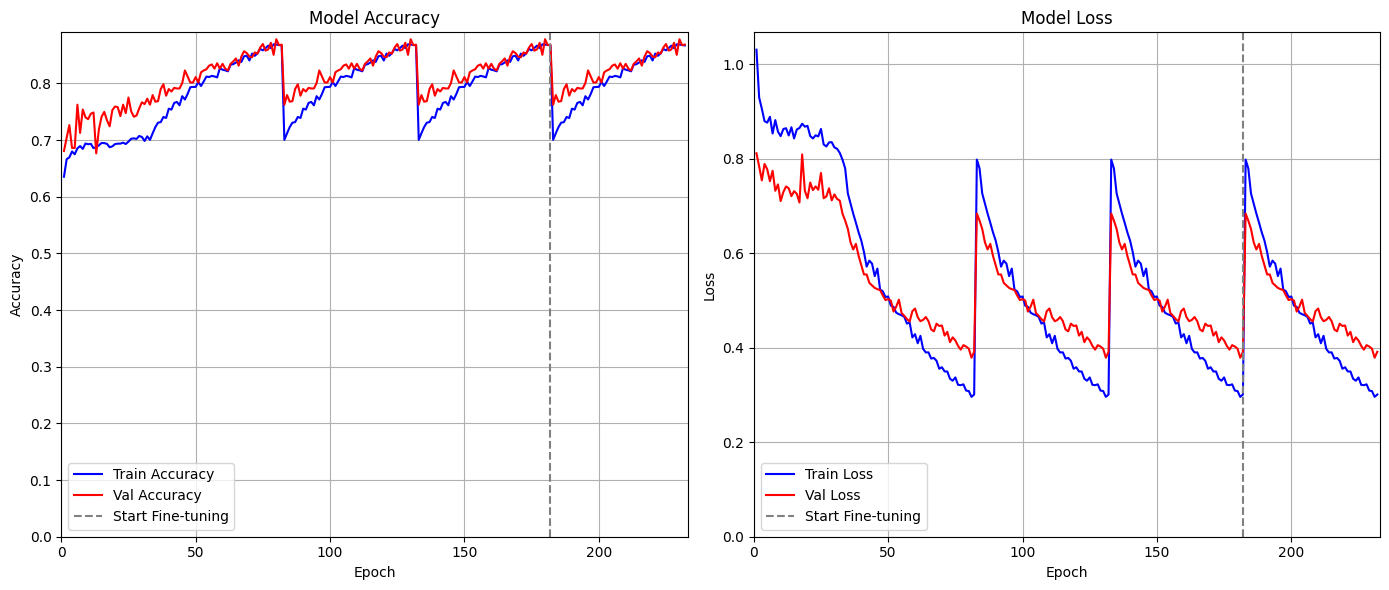


--- Evaluating on Test Set (Final Performance using best fine-tuned weights) ---




Testing:   0%|          | 0/59 [00:00<?, ?batch/s]

Testing:   2%|▏         | 1/59 [00:00<00:18,  3.14batch/s]

Testing:   3%|▎         | 2/59 [00:00<00:11,  4.93batch/s]

Testing:   5%|▌         | 3/59 [00:00<00:09,  5.66batch/s]

Testing:   7%|▋         | 4/59 [00:00<00:09,  5.95batch/s]

Testing:   8%|▊         | 5/59 [00:00<00:08,  6.30batch/s]

Testing:  10%|█         | 6/59 [00:01<00:08,  6.54batch/s]

Testing:  12%|█▏        | 7/59 [00:01<00:07,  6.62batch/s]

Testing:  14%|█▎        | 8/59 [00:01<00:07,  6.80batch/s]

Testing:  15%|█▌        | 9/59 [00:01<00:07,  6.82batch/s]

Testing:  17%|█▋        | 10/59 [00:01<00:06,  7.17batch/s]

Testing:  19%|█▊        | 11/59 [00:01<00:06,  7.17batch/s]

Testing:  20%|██        | 12/59 [00:01<00:06,  7.29batch/s]

Testing:  22%|██▏       | 13/59 [00:01<00:06,  7.29batch/s]

Testing:  24%|██▎       | 14/59 [00:02<00:06,  7.27batch/s]

Testing:  25%|██▌       | 15/59 [00:02<00:06,  7.09batch/s]

Testing:  27%|██▋       | 16/59 [00:02<0


Test Loss: 0.4578
Test Accuracy: 0.8665
Target accuracy (> 0.85) achieved on the test set.

Classification Report (Test Set):
                              precision    recall  f1-score   support

        Basal_cell_carcinoma     0.7414    0.8431    0.7890        51
Benign_keratosislike_lesions     0.6809    0.8727    0.7649       110
                    Melanoma     0.6923    0.7232    0.7074       112
            Melanocytic_nevi     0.9522    0.8912    0.9207       671

                    accuracy                         0.8665       944
                   macro avg     0.7667    0.8326    0.7955       944
                weighted avg     0.8784    0.8665    0.8701       944


Confusion Matrix (Test Set):


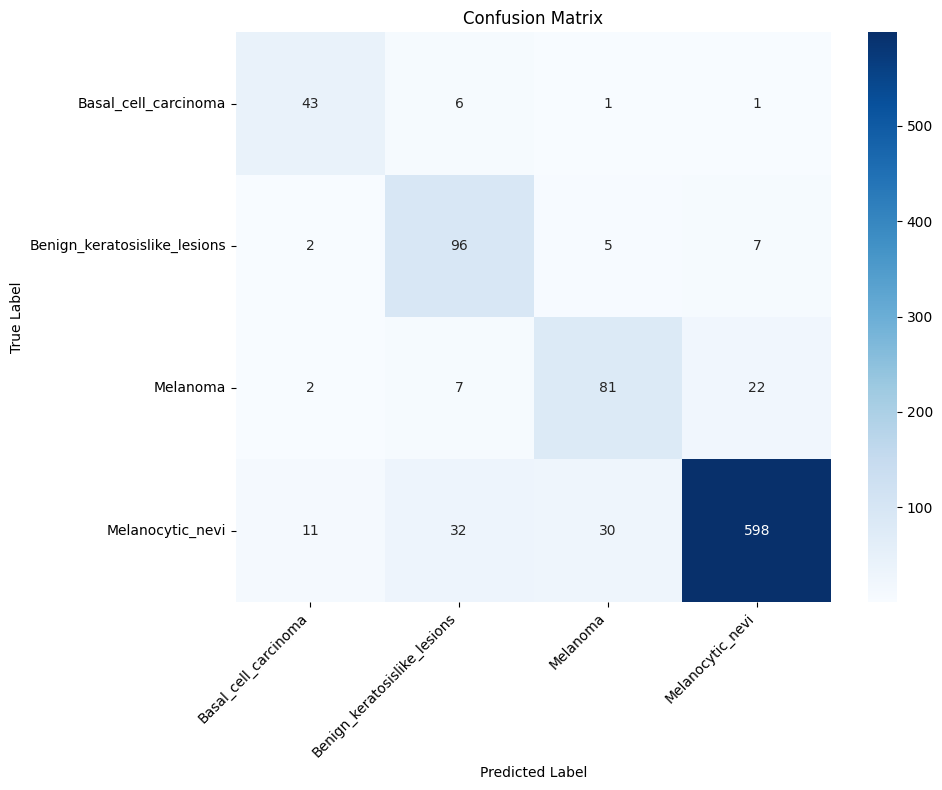


--- End of Evaluation Script ---


In [ ]:
# ===  10: Evaluation and Visualization ===

def plot_history_torch_robust(history1, history2=None):
    h1 = history1 if isinstance(history1, dict) else {}; h2 = history2 if isinstance(history2, dict) else {}
    acc1 = list(h1.get('train_acc', [])); val_acc1 = list(h1.get('val_acc', []))
    loss1 = list(h1.get('train_loss', [])); val_loss1 = list(h1.get('val_loss', []))
    epochs1_count = len(acc1)
    acc2 = list(h2.get('train_acc', [])); val_acc2 = list(h2.get('val_acc', []))
    loss2 = list(h2.get('train_loss', [])); val_loss2 = list(h2.get('val_loss', []))
    epochs2_count = len(acc2); history2_data_present = False
    if epochs2_count > 0: acc_total=acc1+acc2; val_acc_total=val_acc1+val_acc2; loss_total=loss1+loss2; val_loss_total=val_loss1+val_loss2; history2_data_present=True
    else: acc_total=acc1; val_acc_total=val_acc1; loss_total=loss1; val_loss_total=val_loss1
    epochs_range = range(1, len(acc_total) + 1)
    if not epochs_range: print("No history data found."); return
    plt.figure(figsize=(14, 6)); plt.subplot(1, 2, 1); plt.plot(epochs_range, acc_total, 'b-', label='Train Accuracy'); plt.plot(epochs_range, val_acc_total, 'r-', label='Val Accuracy')
    if history2_data_present and epochs1_count > 0: plt.axvline(x=epochs1_count, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.ylim(bottom=0); plt.xlim(left=0, right=len(acc_total)+1); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(epochs_range, loss_total, 'b-', label='Train Loss'); plt.plot(epochs_range, val_loss_total, 'r-', label='Val Loss')
    if history2_data_present and epochs1_count > 0: plt.axvline(x=epochs1_count, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.ylim(bottom=0); plt.xlim(left=0, right=len(acc_total)+1); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

# training visualization
print("\nPlotting final training history...")
history1_to_plot = history_stage1 if 'history_stage1' in locals() else None
history2_to_plot = history_stage2 if 'history_stage2' in locals() else None
if history1_to_plot: plot_history_torch_robust(history1_to_plot, history2_to_plot)
else: print("History data ('history_stage1') not found.")


# --- Evaluation on test set ---
if 'test_loader' in locals() and 'model' in locals() and 'device' in locals():
    model.eval()
    all_labels = []; all_preds = []; test_loss_sum = 0.0; total_test_samples = 0
    criterion_available = 'criterion' in locals()

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=False, unit="batch")
        for batch_data in progress_bar:
            if batch_data is None or batch_data[0] is None or batch_data[1] is None: continue
            inputs, labels = batch_data
            if inputs.nelement() == 0: continue

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion_available:
                try:
                     loss = criterion(outputs, labels)
                     if not (torch.isnan(loss) or torch.isinf(loss)): test_loss_sum += loss.item() * inputs.size(0)
                except Exception as e: print(f"W: Loss calc test batch: {e}"); criterion_available = False

            _, predicted_classes = torch.max(outputs, 1)
            total_test_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy()); all_preds.extend(predicted_classes.cpu().numpy())

    if total_test_samples > 0:
        test_loss_final = test_loss_sum / total_test_samples if criterion_available and total_test_samples > 0 else float('nan')
        test_acc_final = sum(1 for t, p in zip(all_labels, all_preds) if t == p) / total_test_samples

        print(f"\nTest Loss: {test_loss_final:.4f}"); print(f"Test Accuracy: {test_acc_final:.4f}")
        print("\nClassification Report (Test Set):")
        if 'report_target_names' in locals() and report_target_names is not None: target_names_for_report = report_target_names
        elif 'num_classes' in locals(): target_names_for_report = [f"Class {i}" for i in range(num_classes)]; print("W: Using generic class labels.")
        else: target_names_for_report = None; print("W: Using numerical labels.")
        print(classification_report(all_labels, all_preds, target_names=target_names_for_report, digits=4))

        print("\nConfusion Matrix (Test Set):")
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        if target_names_for_report: axis_labels = target_names_for_report
        elif 'num_classes' in locals(): axis_labels = range(num_classes)
        else: axis_labels = np.unique(all_labels + all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=axis_labels, yticklabels=axis_labels)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
        if isinstance(axis_labels, list) and isinstance(axis_labels[0], str): plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
        plt.tight_layout(); plt.show()
    else: print("No samples processed in test set.")
else: print("Test dataset (test_loader) or model not available for evaluation.")

In [ ]:
Project Summary for Report

Project Objective: To develop a deep learning model for the classification of skin diseases using dermoscopic images from the HAM10000 dataset. The target metric was to achieve an accuracy exceeding 85% on the test set.

Initial Data and Approach: The HAM10000 dataset was utilized. The initial approach involved filtering classes with fewer than 500 samples and using Keras with ImageDataGenerator for data loading and augmentation. A significant challenge observed was low validation accuracy, indicating that the model was not learning effectively.

Key Challenges and Solutions:

Data Leakage: The primary initial issue stemmed from applying augmentation before splitting the data into training, validation, and test sets. This potentially allowed augmented copies of the same images to exist across different splits, distorting the model's performance evaluation.

Solution: The data processing pipeline was restructured: data splitting into train/validation/test sets is now performed strictly before any augmentation.

Inefficient Augmentation and Data Loading: The use of ImageDataGenerator and potential pre-augmentation was replaced with a more flexible and potentially more efficient pipeline.

Solution: A pipeline based on PyTorch's torch.utils.data.Dataset and DataLoader was implemented. Augmentation is applied "on-the-fly" only to the training set using the Albumentations library, incorporating relevant transformations (rotations, flips, brightness/contrast adjustments, etc.).

Class Imbalance: The HAM10000 dataset is inherently imbalanced. Even after filtering rare classes, a significant imbalance remained.

Solution: Instead of resampling techniques (oversampling/undersampling), class weighting was employed. Weights inversely proportional to class frequencies in the training set were calculated and passed to the loss function (nn.CrossEntropyLoss), encouraging the model to pay more attention to minority classes.

Model Selection and Training Strategy: An effective architecture and training methodology were required.

Solution: An EfficientNet-B0 model, pre-trained on ImageNet, was used as the base (Transfer Learning). A two-stage training strategy was adopted:

Stage 1 (Feature Extraction): The base model's weights were frozen, and only the newly added classification layer was trained with a relatively high learning rate.

Stage 2 (Fine-tuning): All layers of the base model were unfrozen, and training continued with a significantly lower learning rate to fine-tune the pre-trained features to the specifics of the skin lesion dataset.

Environment and Framework Issues: During development, challenges arose related to RAM limitations in Google Colab, version incompatibilities within TensorFlow/Keras and its dependencies, and configuring the local GPU environment for TensorFlow.

Solution: The project transitioned to the PyTorch framework. The user's local environment, equipped with an NVIDIA RTX 4060 Laptop GPU, was configured for PyTorch. The data pipeline and model were fully migrated. Debugging addressed framework-specific errors (e.g., NameError, syntax) and visualization issues (ipywidgets/tqdm).

Final Approach:

Framework: PyTorch.

Model: EfficientNet-B0 (from torchvision.models) with pre-trained ImageNet weights.

Data Preparation: Filtering of classes (< 500 samples), custom Dataset class with Albumentations for on-the-fly augmentation (train) and normalization (val/test), DataLoader for batching.

Class Balancing: Class weighting applied within nn.CrossEntropyLoss.

Training: Two-stage strategy (feature extraction + fine-tuning) using Adam optimizer and ReduceLROnPlateau learning rate scheduler.

Model Saving: Saving the state_dict of the best performing model based on validation loss at each stage.

Result: The final model achieved an accuracy of 86.65% on the held-out test set, successfully exceeding the project's target of 85%.

References and Best Practices

The development process drew upon established best practices and concepts from the following areas:

Transfer Learning in Computer Vision:

Yosinski, J., Clune, J., Bengio, Y., & Lipson, H. (2014). How transferable are features in deep neural networks?. Advances in neural information processing systems (NeurIPS). (arXiv:1411.1792)

PyTorch Tutorial: Transfer Learning for Computer Vision Tutorial

Keras Guide: Transfer learning & fine-tuning (Principles are applicable across frameworks)

Fine-tuning Pre-trained Models: (Covered within Transfer Learning resources)

Modern CNN Architectures (EfficientNet):

Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. International Conference on Machine Learning (ICML). (arXiv:1905.11946)

Torchvision Documentation: EfficientNet

Data Augmentation for Medical Images:

Buslaev, A., et al. (2020). Albumentations: Fast and Flexible Image Augmentations. Information. (arXiv:1809.06839)

Shorten, C., & Khoshgoftaar, T. M. (2019). A survey on Image Data Augmentation for Deep Learning. Journal of Big Data.

Handling Imbalanced Datasets:

PyTorch Documentation: CrossEntropyLoss (see weight parameter).

Scikit-learn Documentation: compute_class_weight.

He, H., & Garcia, E. A. (2009). Learning from imbalanced data. IEEE Transactions on knowledge and data engineering.

Deep Learning for Medical Image Analysis:

Litjens, G., et al. (2017). A survey on deep learning in medical image analysis. Medical image analysis. (arXiv:1702.05747)

Esteva, A., et al. (2017). Dermatologist-level classification of skin cancer with deep neural networks. Nature.

Papers With Code: HAM10000 Leaderboard (Illustrates common techniques for this dataset).

Efficient Data Pipelines in PyTorch:

PyTorch Documentation: Dataset & DataLoader


FileNotFoundError: Cannot find file: trained_model_weights/efficientnet_b0_params.json